In [14]:
#hide
! [ -e /content ] && pip3 install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [12]:
#hide
from fastbook import *

# A fastai Learner from Scratch

This final chapter (other than the conclusion and the online chapters) is going to look a bit different. It contains far more code and far less prose than the previous chapters. We will introduce new Python keywords and libraries without discussing them. This chapter is meant to be the start of a significant research project for you. You see, we are going to implement many of the key pieces of the fastai and PyTorch APIs from scratch, building on nothing other than the components that we developed in <<chapter_foundations>>! The key goal here is to end up with your own `Learner` class, and some callbacks—enough to be able to train a model on Imagenette, including examples of each of the key techniques we've studied. On the way to building `Learner`, we will create our own version of `Module`, `Parameter`, and parallel `DataLoader` so you have a very good idea of what those PyTorch classes do.

The end-of-chapter questionnaire is particularly important for this chapter. This is where we will be pointing you in the many interesting directions that you could take, using this chapter as your starting point. We suggest that you follow along with this chapter on your computer, and do lots of experiments, web searches, and whatever else you need to understand what's going on. You've built up the skills and expertise to do this in the rest of this book, so we think you are going to do great!

Let's begin by gathering (manually) some data.

## Data

Have a look at the source to `untar_data` to see how it works. We'll use it here to access the 160-pixel version of Imagenette for use in this chapter:

In [4]:
??untar_data

Signature:
untar_data(
    url: 'str',
    archive: 'Path' = None,
    data: 'Path' = None,
    c_key: 'str' = 'data',
    force_download: 'bool' = False,
    base: 'str' = '~/.fastai',
) -> 'Path'
Source:   
def untar_data(
    url:str, # File to download
    archive:Path=None, # Optional override for `Config`'s `archive` key
    data:Path=None, # Optional override for `Config`'s `data` key
    c_key:str='data', # Key in `Config` where to extract file
    force_download:bool=False, # Setting to `True` will overwrite any existing copy of data
    base:str='~/.fastai' # Directory containing config file and base of relative paths
) -> Path: # Path to extracted file(s)
    "Download `url` using `FastDownload.get`"
    d = FastDownload(fastai_cfg(), module=fastai.data, archive=archive, data=data, base=base)
    return d.get(url, force=force_download, extract_key=c_key)
File:      /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/data/external.py
Type:  

In [10]:
??URLs

Init signature: URLs()
Source:        
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    MDL = 'http://files.fast.ai/models/'
    GOOGLE = 'https://storage.googleapis.com/'
    S3  = 'https://s3.amazonaws.com/fast-ai-'
    URL = f'{S3}sample/'

    S3_IMAGE    = f'{S3}imageclas/'
    S3_IMAGELOC = f'{S3}imagelocal/'
    S3_AUDI     = f'{S3}audio/'
    S3_NLP      = f'{S3}nlp/'
    S3_COCO     = f'{S3}coco/'
    S3_MODEL    = f'{S3}modelzoo/'

    # main datasets
    ADULT_SAMPLE        = f'{URL}adult_sample.tgz'
    BIWI_SAMPLE         = f'{URL}biwi_sample.tgz'
    CIFAR               = f'{URL}cifar10.tgz'
    COCO_SAMPLE         = f'{S3_COCO}coco_sample.tgz'
    COCO_TINY           = f'{S3_COCO}coco_tiny.tgz'
    HUMAN_NUMBERS       = f'{URL}human_numbers.tgz'
    IMDB                = f'{S3_NLP}imdb.tgz'
    IMDB_SAMPLE         = f'{URL}imdb_sample.tgz'
    ML_SAMPLE           = f'{URL}movie_lens_sample.tgz'
    ML_100k             = 'ht

In [16]:
path = untar_data(URLs.IMAGENETTE_160)

In [17]:
path

Path('/Users/alextianyima/.fastai/data/imagenette2-160')

To access the image files, we can use `get_image_files`:

In [18]:
??get_image_files

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/data/transforms.py
Type:      function

In [19]:
??get_files

Signature:
get_files(
    path,
    extensions=None,
    recurse=True,
    folders=None,
    followlinks=True,
)
Source:   
def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(pa

In [20]:
t = get_image_files(path)
t[0]

Path('/Users/alextianyima/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG')

Or we could do the same thing using just Python's standard library, with `glob`:

In [21]:
??L

Init signature: L(items=None, *rest, use_list=False, match=None)
Source:        
class L(GetAttr, CollBase, metaclass=_L_Meta):
    "Behaves like a list of `items` but can also index with list of indices or masks"
    _default='items'
    def __init__(self, items=None, *rest, use_list=False, match=None):
        if (use_list is not None) or not is_array(items):
            items = listify(items, *rest, use_list=use_list, match=match)
        super().__init__(items)

    @property
    def _xtra(self): return None
    def _new(self, items, *args, **kwargs): return type(self)(items, *args, use_list=None, **kwargs)
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else L(self._get(idx), use_list=None)
    def copy(self): return self._new(self.items.copy())

    def _get(self, i):
        if is_indexer(i) or isinstance(i,slice): return getattr(self.items,'iloc',self.items)[i]
        i = mask2idxs(i)
        return (self.items.iloc[list(i)] if hasattr(self.items,'iloc

In [23]:
??glob

Signature:
glob(
    pathname,
    *,
    root_dir=None,
    dir_fd=None,
    recursive=False,
    include_hidden=False,
)
Source:   
def glob(pathname, *, root_dir=None, dir_fd=None, recursive=False,
        include_hidden=False):
    """Return a list of paths matching a pathname pattern.

    The pattern may contain simple shell-style wildcards a la
    fnmatch. Unlike fnmatch, filenames starting with a
    dot are special cases that are not matched by '*' and '?'
    patterns by default.

    If `include_hidden` is true, the patterns '*', '?', '**'  will match hidden
    directories.

    If `recursive` is true, the pattern '**' will match any files and
    zero or more directories and subdirectories.
    """
    return list(iglob(pathname, root_dir=root_dir, dir_fd=dir_fd, recursive=recursive,
                      include_hidden=include_hidden))
File:      /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/glob.py
Type:      function

`.map(Path)` convert strings returned by `glob()` to `Path` objects.

In [25]:
from glob import glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('/Users/alextianyima/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG')

If you look at the source for `get_image_files`, you'll see it uses Python's `os.walk`; this is a faster and more flexible function than `glob`, so be sure to try it out.

We can open an image with the Python Imaging Library's `Image` class:

In [58]:
# Trying out using os.walk instead of glob
# Get train and test data and ignore .DStore file at index 0
files_train_strs = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk(f'{path}/train/') for filename in filenames][1:]
files_test_strs = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk(f'{path}/test/') for filename in filenames][1:]

# Create L with the two lists of string paths, concat the two lists and map to Path objects
files_os = L(files_train_strs, files_test_strs).concat().map(Path)
files_os[0]

Path('/Users/alextianyima/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG')

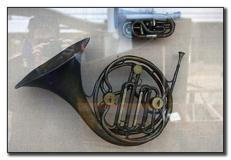

In [60]:
im = Image.open(files[0])
im

In [61]:
im_t = tensor(im)
im_t.shape

torch.Size([160, 231, 3])

That's going to be the basis of our independent variable. For our dependent variable, we can use `Path.parent` from `pathlib`. First we'll need our vocab:

In [63]:
# These are parent folder names
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03394916','n03417042','n03445777','n02102040','n03425413','n03888257','n03028079','n03000684','n01440764','n02979186']

The parent folder names are used because they classify the images. This folder contains images of horns.

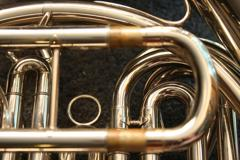

In [64]:
im = Image.open(files[1])
im

...and the reverse mapping, thanks to `L.val2idx`:

In [66]:
??L.val2idx

Signature: L.val2idx(self)
Docstring: Dict from value to index
Source:        def val2idx(self): return val2idx(self)
File:      /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastcore/foundation.py
Type:      function

In [65]:
v2i = lbls.val2idx(); v2i

{'n03394916': 0,
 'n03417042': 1,
 'n03445777': 2,
 'n02102040': 3,
 'n03425413': 4,
 'n03888257': 5,
 'n03028079': 6,
 'n03000684': 7,
 'n01440764': 8,
 'n02979186': 9}

That's all the pieces we need to put together our `Dataset`.

### Dataset

A `Dataset` in PyTorch can be anything that supports indexing (`__getitem__`) and `len`:

`fns` = filenames

In [71]:
class Dataset:
    def __init__(self, fns): self.fns=fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

We need a list of training and validation filenames to pass to `Dataset.__init__`:

In [69]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt] # ~: NOT operator, this line subset the files list
len(train),len(valid)

(9469, 3925)

Now we can try it out:

In [77]:
train_ds,valid_ds = Dataset(train),Dataset(valid)

# x is created by opening the image by filepath, resizing and convert to RGB scale
# Which is why the torch size is [64, 64, 3]: the first two numbers are the size of the image and RGB has 3 channels
# y is created by first getting the parent folder name of the filename and then convert the name to associated index
# Which is why the tensor has only 1 element and the value is 0: it belongs to class 0
x,y = train_ds[0]
x.shape,y

(torch.Size([64, 64, 3]), tensor(0))

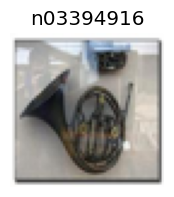

In [79]:
# libls = the list of parent folder names, at index 0 we have the folder name for horn images
show_image(x, title=lbls[y]);

As you see, our dataset is returning the independent and dependent variables as a tuple, which is just what we need. We'll need to be able to collate these into a mini-batch. Generally this is done with `torch.stack`, which is what we'll use here:

In [ ]:
def collate(idxs, ds):
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

Here's a mini-batch with two items, for testing our `collate`:

In [ ]:
x,y = collate([1,2], train_ds)
x.shape,y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

Now that we have a dataset and a collation function, we're ready to create `DataLoader`. We'll add two more things here: an optional `shuffle` for the training set, and a `ProcessPoolExecutor` to do our preprocessing in parallel. A parallel data loader is very important, because opening and decoding a JPEG image is a slow process. One CPU core is not enough to decode images fast enough to keep a modern GPU busy. Here's our `DataLoader` class:

In [ ]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

Let's try it out with our training and validation datasets:

In [ ]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

This data loader is not much slower than PyTorch's, but it's far simpler. So if you're debugging a complex data loading process, don't be afraid to try doing things manually to help you see exactly what's going on.

For normalization, we'll need image statistics. Generally it's fine to calculate these on a single training mini-batch, since precision isn't needed here:

In [ ]:
stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
stats

[tensor([0.4544, 0.4453, 0.4141]), tensor([0.2812, 0.2766, 0.2981])]

Our `Normalize` class just needs to store these stats and apply them (to see why the `to_device` is needed, try commenting it out, and see what happens later in this notebook):

In [ ]:
class Normalize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

We always like to test everything we build in a notebook, as soon as we build it:

In [ ]:
norm = Normalize(stats)
def tfm_x(x): return norm(x).permute((0,3,1,2))

In [ ]:
t = tfm_x(x)
t.mean((0,2,3)),t.std((0,2,3))

(tensor([0.3732, 0.4907, 0.5633]), tensor([1.0212, 1.0311, 1.0131]))

Here `tfm_x` isn't just applying `Normalize`, but is also permuting the axis order from `NHWC` to `NCHW` (see <<chapter_convolutions>> if you need a reminder of what these acronyms refer to). PIL uses `HWC` axis order, which we can't use with PyTorch, hence the need for this `permute`.

That's all we need for the data for our model. So now we need the model itself!

## Module and Parameter

To create a model, we'll need `Module`. To create `Module`, we'll need `Parameter`, so let's start there. Recall that in <<chapter_collab>> we said that the `Parameter` class "doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to include in `parameters`." Here's a definition which does exactly that:

In [ ]:
class Parameter(Tensor):
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

The implementation here is a bit awkward: we have to define the special `__new__` Python method and use the internal PyTorch method `_make_subclass` because, as at the time of writing, PyTorch doesn't otherwise work correctly with this kind of subclassing or provide an officially supported API to do this. This may have been fixed by the time you read this, so look on the book's website to see if there are updated details.

Our `Parameter` now behaves just like a tensor, as we wanted:

In [ ]:
Parameter(tensor(3.))

tensor(3., requires_grad=True)

Now that we have this, we can define `Module`:

In [ ]:
class Module:
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False

    def register_parameters(self, *ps): self.params += ps
    def register_modules   (self, *ms): self.children += ms

    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v

    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)

    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res

    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

The key functionality is in the definition of `parameters`:

```python
self.params + sum([m.parameters() for m in self.children], [])
```

This means that we can ask any `Module` for its parameters, and it will return them, including all its child modules (recursively). But how does it know what its parameters are? It's thanks to implementing Python's special `__setattr__` method, which is called for us any time Python sets an attribute on a class. Our implementation includes this line:

```python
if isinstance(v,Parameter): self.register_parameters(v)
```

As you see, this is where we use our new `Parameter` class as a "marker"—anything of this class is added to our `params`.

Python's `__call__` allows us to define what happens when our object is treated as a function; we just call `forward` (which doesn't exist here, so it'll need to be added by subclasses). Before we do, we'll call a hook, if it's defined. Now you can see that PyTorch hooks aren't doing anything fancy at all—they're just calling any hooks that have been registered.

Other than these pieces of functionality, our `Module` also provides `cuda` and `training` attributes, which we'll use shortly.

Now we can create our first `Module`, which is `ConvLayer`:

In [ ]:
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)

    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act: x = F.relu(x)
        return x

We're not implementing `F.conv2d` from scratch, since you should have already done that (using `unfold`) in the questionnaire in <<chapter_foundations>>. Instead, we're just creating a small class that wraps it up along with bias and weight initialization. Let's check that it works correctly with `Module.parameters`:

In [ ]:
l = ConvLayer(3, 4)
len(l.parameters())

2

And that we can call it (which will result in `forward` being called):

In [ ]:
xbt = tfm_x(xb)
r = l(xbt)
r.shape

torch.Size([128, 4, 64, 64])

In the same way, we can implement `Linear`:

In [ ]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)

    def forward(self, x): return x@self.w.t() + self.b

and test if it works:

In [ ]:
l = Linear(4,2)
r = l(torch.ones(3,4))
r.shape

torch.Size([3, 2])

Let's also create a testing module to check that if we include multiple parameters as attributes, they are all correctly registered:

In [ ]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2)

Since we have a conv layer and a linear layer, each of which has weights and biases, we'd expect four parameters in total:

In [ ]:
t = T()
len(t.parameters())

4

We should also find that calling `cuda` on this class puts all these parameters on the GPU:

In [ ]:
t.cuda()
t.l.w.device

device(type='cuda', index=5)

We can now use those pieces to create a CNN.

### Simple CNN

As we've seen, a `Sequential` class makes many architectures easier to implement, so let's make one:

In [ ]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

The `forward` method here just calls each layer in turn. Note that we have to use the `register_modules` method we defined in `Module`, since otherwise the contents of `layers` won't appear in `parameters`.

> important: All The Code is Here: Remember that we're not using any PyTorch functionality for modules here; we're defining everything ourselves. So if you're not sure what `register_modules` does, or why it's needed, have another look at our code for `Module` to see what we wrote!

We can create a simplified `AdaptivePool` that only handles pooling to a 1×1 output, and flattens it as well, by just using `mean`:

In [ ]:
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

That's enough for us to create a CNN!

In [ ]:
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

Let's see if our parameters are all being registered correctly:

In [ ]:
m = simple_cnn()
len(m.parameters())

10

Now we can try adding a hook. Note that we've only left room for one hook in `Module`; you could make it a list, or use something like `Pipeline` to run a few as a single function:

In [ ]:
def print_stats(outp, inp): print (outp.mean().item(),outp.std().item())
for i in range(4): m.layers[i].hook = print_stats

r = m(xbt)
r.shape

0.5239089727401733 0.8776043057441711
0.43470510840415955 0.8347987532615662
0.4357188045978546 0.7621666193008423
0.46562111377716064 0.7416611313819885


torch.Size([128, 10])

We have data and model. Now we need a loss function.

## Loss

We've already seen how to define "negative log likelihood":

In [ ]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

Well actually, there's no log here, since we're using the same definition as PyTorch. That means we need to put the log together with softmax:

In [ ]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

sm = log_softmax(r); sm[0][0]

tensor(-1.2790, grad_fn=<SelectBackward>)

Combining these gives us our cross-entropy loss:

In [ ]:
loss = nll(sm, yb)
loss

tensor(2.5666, grad_fn=<NegBackward>)

Note that the formula:

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1))).log()`:

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
sm = log_softmax(r); sm[0][0]

tensor(-1.2790, grad_fn=<SelectBackward>)

Then, there is a more stable way to compute the log of the sum of exponentials, called the [LogSumExp](https://en.wikipedia.org/wiki/LogSumExp) trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where $a$ is the maximum of $x_{j}$.


Here's the same thing in code:

In [ ]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(True)

We'll put that into a function:

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

tensor(3.9784, grad_fn=<SelectBackward>)

so we can use it for our `log_softmax` function:

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

Which gives the same result as before:

In [ ]:
sm = log_softmax(r); sm[0][0]

tensor(-1.2790, grad_fn=<SelectBackward>)

We can use these to create `cross_entropy`:

In [ ]:
def cross_entropy(preds, yb): return nll(log_softmax(preds), yb).mean()

Let's now combine all those pieces together to create a `Learner`.

## Learner

We have data, a model, and a loss function; we only need one more thing before we can fit a model, and that's an optimizer! Here's SGD:

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

As we've seen in this book, life is easier with a `Learner`. The `Learner` class needs to know our training and validation sets, which means we need `DataLoaders` to store them. We don't need any other functionality, just a place to store them and access them:

In [ ]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

Now we're ready to create our `Learner` class:

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')

    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')

    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

This is the largest class we've created in the book, but each method is quite small, so by looking at each in turn you should be able to follow what's going on.

The main method we'll be calling is `fit`. This loops with:

```python
for self.epoch in range(n_epochs)
```

and at each epoch calls `self.one_epoch` for each of `train=True` and then `train=False`. Then `self.one_epoch` calls `self.one_batch` for each batch in `dls.train` or `dls.valid`, as appropriate (after wrapping the `DataLoader` in `fastprogress.progress_bar`. Finally, `self.one_batch` follows the usual set of steps to fit one mini-batch that we've seen throughout this book.

Before and after each step, `Learner` calls `self`, which calls `__call__` (which is standard Python functionality). `__call__` uses `getattr(cb,name)` on each callback in `self.cbs`, which is a Python built-in function that returns the attribute (a method, in this case) with the requested name. So, for instance, `self('before_fit')` will call `cb.before_fit()` for each callback where that method is defined.

As you can see, `Learner` is really just using our standard training loop, except that it's also calling callbacks at appropriate times. So let's define some callbacks!

### Callbacks

In `Learner.__init__` we have:

```python
for cb in cbs: cb.learner = self
```

In other words, every callback knows what learner it is used in. This is critical, since otherwise a callback can't get information from the learner, or change things in the learner. Because getting information from the learner is so common, we make that easier by defining `Callback` as a subclass of `GetAttr`, with a default attribute of `learner`:

In [ ]:
class Callback(GetAttr): _default='learner'

`GetAttr` is a fastai class that implements Python's standard `__getattr__` and `__dir__` methods for you, such that any time you try to access an attribute that doesn't exist, it passes the request along to whatever you have defined as `_default`.

For instance, we want to move all model parameters to the GPU automatically at the start of `fit`. We could do this by defining `before_fit` as `self.learner.model.cuda()`; however, because `learner` is the default attribute, and we have `SetupLearnerCB` inherit from `Callback` (which inherits from `GetAttr`), we can remove the `.learner` and just call `self.model.cuda()`:

In [ ]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb),yb

    def before_fit(self): self.model.cuda()

In `SetupLearnerCB` we also move each mini-batch to the GPU, by calling `to_device(self.batch)` (we could also have used the longer `to_device(self.learner.batch)`. Note however that in the line `self.learner.batch = tfm_x(xb),yb` we can't remove `.learner`, because here we're *setting* the attribute, not getting it.

Before we try our `Learner` out, let's create a callback to track and print progress. Otherwise we won't really know if it's working properly:

In [ ]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]

    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)

    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

Now we're ready to use our `Learner` for the first time!

In [ ]:
cbs = [SetupLearnerCB(),TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1275552130636814 0.2314922378287042


0 False 1.9942575636942674 0.2991082802547771


It's quite amazing to realize that we can implement all the key ideas from fastai's `Learner` in so little code! Let's now add some learning rate scheduling.

### Scheduling the Learning Rate

If we're going to get good results, we'll want an LR finder and 1cycle training. These are both *annealing* callbacks—that is, they are gradually changing hyperparameters as we train. Here's `LRFinder`:

In [ ]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6

    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

This shows how we're using `CancelFitException`, which is itself an empty class, only used to signify the type of exception. You can see in `Learner` that this exception is caught. (You should add and test `CancelBatchException`, `CancelEpochException`, etc. yourself.) Let's try it out, by adding it to our list of callbacks:

In [ ]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.6336045582954903 0.11014890695955222


0 False 2.230653363853503 0.18318471337579617


And take a look at the results:

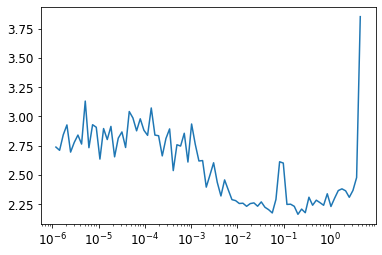

In [ ]:
plt.plot(lrfind.lrs[:-2],lrfind.losses[:-2])
plt.xscale('log')

Now we can define our `OneCycle` training callback:

In [ ]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

We'll try an LR of 0.1:

In [ ]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

Let's fit for a while and see how it looks (we won't show all the output in the book—try it in the notebook to see the results):

In [ ]:
#hide_output
learn.fit(8)

Finally, we'll check that the learning rate followed the schedule we defined (as you see, we're not using cosine annealing here):

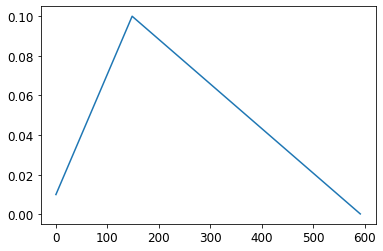

In [ ]:
plt.plot(onecyc.lrs);

## Conclusion

We have explored how the key concepts of the fastai library are implemented by re-implementing them in this chapter. Since it's mostly full of code, you should definitely try to experiment with it by looking at the corresponding notebook on the book's website. Now that you know how it's built, as a next step be sure to check out the intermediate and advanced tutorials in the fastai documentation to learn how to customize every bit of the library.

## Questionnaire

> tip: Experiments: For the questions here that ask you to explain what some function or class is, you should also complete your own code experiments.

1. What is `glob`?
1. How do you open an image with the Python imaging library?
1. What does `L.map` do?
1. What does `Self` do?
1. What is `L.val2idx`?
1. What methods do you need to implement to create your own `Dataset`?
1. Why do we call `convert` when we open an image from Imagenette?
1. What does `~` do? How is it useful for splitting training and validation sets?
1. Does `~` work with the `L` or `Tensor` classes? What about NumPy arrays, Python lists, or pandas DataFrames?
1. What is `ProcessPoolExecutor`?
1. How does `L.range(self.ds)` work?
1. What is `__iter__`?
1. What is `first`?
1. What is `permute`? Why is it needed?
1. What is a recursive function? How does it help us define the `parameters` method?
1. Write a recursive function that returns the first 20 items of the Fibonacci sequence.
1. What is `super`?
1. Why do subclasses of `Module` need to override `forward` instead of defining `__call__`?
1. In `ConvLayer`, why does `init` depend on `act`?
1. Why does `Sequential` need to call `register_modules`?
1. Write a hook that prints the shape of every layer's activations.
1. What is "LogSumExp"?
1. Why is `log_softmax` useful?
1. What is `GetAttr`? How is it helpful for callbacks?
1. Reimplement one of the callbacks in this chapter without inheriting from `Callback` or `GetAttr`.
1. What does `Learner.__call__` do?
1. What is `getattr`? (Note the case difference to `GetAttr`!)
1. Why is there a `try` block in `fit`?
1. Why do we check for `model.training` in `one_batch`?
1. What is `store_attr`?
1. What is the purpose of `TrackResults.before_epoch`?
1. What does `model.cuda` do? How does it work?
1. Why do we need to check `model.training` in `LRFinder` and `OneCycle`?
1. Use cosine annealing in `OneCycle`.

### Further Research

1. Write `resnet18` from scratch (refer to <<chapter_resnet>> as needed), and train it with the `Learner` in this chapter.
1. Implement a batchnorm layer from scratch and use it in your `resnet18`.
1. Write a Mixup callback for use in this chapter.
1. Add momentum to SGD.
1. Pick a few features that you're interested in from fastai (or any other library) and implement them in this chapter.
1. Pick a research paper that's not yet implemented in fastai or PyTorch and implement it in this chapter.
  - Port it over to fastai.
  - Submit a pull request to fastai, or create your own extension module and release it.
  - Hint: you may find it helpful to use [`nbdev`](https://nbdev.fast.ai/) to create and deploy your package.